In [1]:
#Capsnet model for human brain dataset
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

USE_CUDA = False

In [2]:
x = pd.read_table('/Users/marong/Dropbox/lakeFrontal_norm_counts_all.txt', sep= '\t').iloc[:,1:]
y = pd.read_table('/Users/marong/Dropbox/lakeFrontal_celltypes.txt', sep= '\t')['Celltype']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [3]:
# extract info and reorganize the data
x = torch.FloatTensor(x.values)
y_labels = set(y)
y_label_dict = dict(zip(y_labels, range(0, len(y_labels))))
y_index = [y_label_dict[i] for i in y]

np.random.seed(888)
rand_index = np.random.permutation(len(y_index))
x_data = x[torch.tensor(rand_index),:]
y_data = [y_index[i] for i in rand_index]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
X_train = X_train.view(-1, 1,21749)
X_test = X_test.view(-1, 1,21749)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=50)

In [6]:
print(X_train.shape)
print(len(y_train))
print(X_valid.shape)
print(len(y_valid))
print(X_test.shape)
print(len(y_test))

torch.Size([6438, 1, 21749])
6438
torch.Size([805, 1, 21749])
805
torch.Size([805, 1, 21749])
805


In [76]:
from torch.utils.data import DataLoader, TensorDataset

# create 
train_data = TensorDataset(X_train, torch.LongTensor(y_train))
valid_data = TensorDataset(X_valid, torch.LongTensor(y_valid))
test_data = TensorDataset(X_test, torch.LongTensor(y_test))

# dataloaders 
batch_size = 100
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last =True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last = True)


# check one of the batches
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) 
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) 
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([100, 1, 21749])
Sample input: 
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])

Sample label size:  torch.Size([100])
Sample label: 
 tensor([4, 5, 0, 4, 5, 1, 2, 4, 1, 4, 4, 4, 4, 4, 4, 5, 2, 2, 2, 4, 4, 4, 4, 4,
        2, 4, 1, 4, 4, 5, 2, 4, 5, 4, 2, 4, 2, 2, 4, 5, 4, 4, 4, 0, 4, 2, 4, 4,
        4, 4, 1, 4, 4, 5, 5, 4, 4, 2, 4, 4, 2, 2, 4, 0, 4, 2, 4, 4, 5, 4, 4, 4,
        5, 2, 6, 4, 7, 4, 2, 1, 2, 4, 2, 4, 4, 4, 4, 0, 0, 2, 1, 5, 4, 4, 4, 2,
        4, 4, 4, 2])


In [83]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_feature = 21749, out_feature=256):
        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Linear(in_feature, out_feature)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), 256, -1)

        return self.squash(u)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor
    
# output 100 , 256 , 8

In [84]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=8, num_routes=256, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        num_iterations = 3

        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)
        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)
        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))

        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor
    
    
# output torch.Size([100, 8, 16, 1])

In [85]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 21749),
            nn.Sigmoid()
        )
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes)
        
        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(8))
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)
        reconstructions = self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        reconstructions = reconstructions.view(-1, 1, 21749)
        
        return reconstructions, masked

In [86]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()

        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.digit_capsules(
            self.primary_capsules(data))

        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)

    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

In [93]:
capsule_net = CapsNet()
optimizer = Adam(capsule_net.parameters())

batch_size = 100
n_epochs = 30

In [94]:
# Main function
early_stop_time = 0
max_accuracy = -1
early_stop = False

for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    for batch_id, (data, target) in enumerate(train_loader):
        
        target = torch.sparse.torch.eye(8).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)
        data = data.float()
        
        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()

        train_loss += loss.data
        if batch_id %10 ==0: 
            print(batch_id)

        if batch_id % 100 == 0:
            print("train accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                                         np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))

    print(train_loss / len(train_loader))

    # Valid Dataset
    capsule_net.eval()
    valid_loss = 0
    for batch_id, (data, target) in enumerate(valid_loader):

        target = torch.sparse.torch.eye(8).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)
        data = data.float()
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        valid_loss += loss.data

        if batch_id % 100 == 0:
            print("Valid accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                                        np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
            
            val_accu = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size)
            if val_accu >= max_accuracy:
                max_accuracy = val_accu
                #early_stop_time = 0
            else:
                early_stop = True
                #early_stop_time += 1

    if early_stop == True:
        break

    print(valid_loss / len(valid_loader))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


0
train accuracy: 0.15
10
20
30
40
50
60
tensor(0.1826)
Valid accuracy: 0.92
tensor(0.0664)
0
train accuracy: 0.99
10
20
30
40
50
60
tensor(0.0347)
Valid accuracy: 0.95
tensor(0.0662)
0
train accuracy: 0.98
10
20
30
40
50
60
tensor(0.0124)
Valid accuracy: 0.96
tensor(0.0646)
0
train accuracy: 1.0
10
20
30
40
50
60
tensor(0.0043)
Valid accuracy: 0.94


In [ ]:
torch.save(capsule_net.state_dict(), '/Users/marong/Dropbox/CG_project/Capsnet/capsnet_fc_brain.pth')

In [699]:
# Testing the model
capsule_net.eval()
pred_results = []
test_loss = 0
accuracy = []
y_pred, y_true = [], []
for batch_id, (data, target) in enumerate(test_loader):
    target = torch.sparse.torch.eye(8).index_select(dim=0, index=target)
    data, target = Variable(data), Variable(target)
    data = data.float()
    output, reconstructions, masked = capsule_net(data)
    pred_results.append((output,reconstructions,masked))
    loss = capsule_net.loss(data, output, target, reconstructions)

    test_loss += loss.data
    yp= np.argmax(masked.data.cpu().numpy(), 1)
    yt = np.argmax(target.data.cpu().numpy(), 1)
    y_pred = y_pred + list(yp)
    y_true = y_true + list(yt)

    
    acc =sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size)
    
    print("Test accuracy:", acc)
    accuracy.append(acc)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Test accuracy: 0.99
Test accuracy: 0.96
Test accuracy: 0.98
Test accuracy: 0.97
Test accuracy: 0.93
Test accuracy: 0.93
Test accuracy: 0.95
Test accuracy: 0.98


In [837]:
from sklearn.metrics import precision_recall_fscore_support
print(np.mean(accuracy))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

0.9612499999999999
(0.9640733387985327, 0.96125, 0.9621852086136531, None)


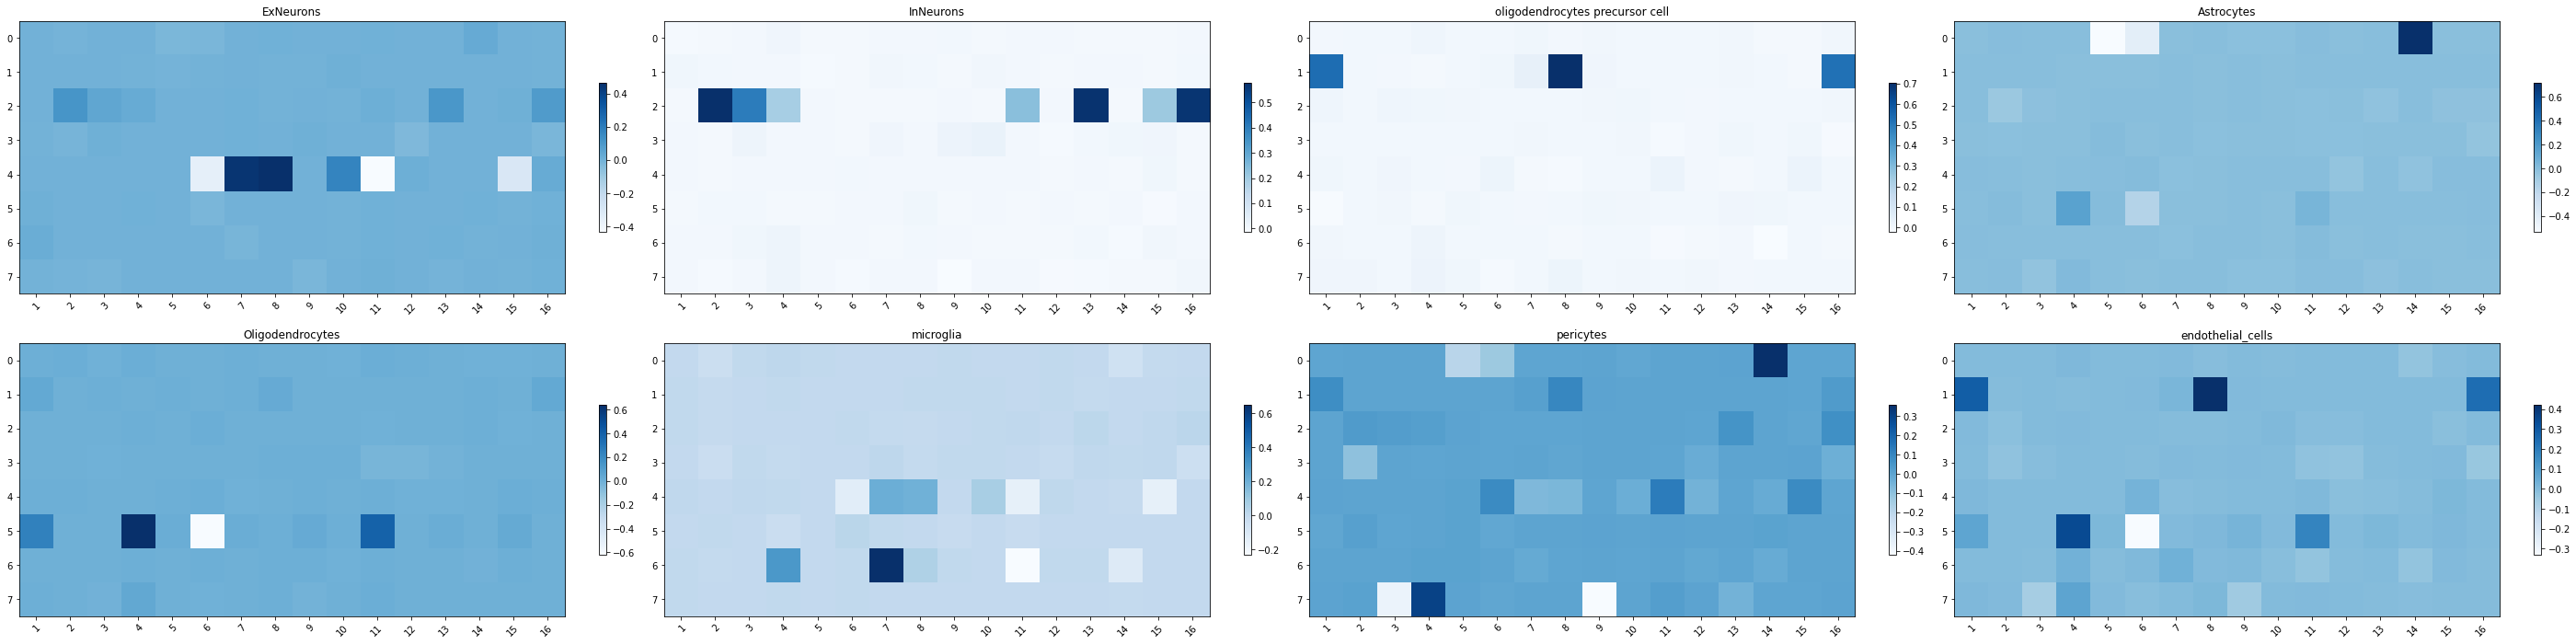

In [685]:
# primary capsules and cell type 
tt = [i[0] for i in pred_results]
ex = torch.stack(tt,dim=0 )
ex = ex.view(800, 8, 16)

cell_type_index = [0, 2 , 4, 5,8,108, 190,729]
cell_type_value = [ex[i] for i in cell_type_index]
cell_type_label = [y_true[i] for i in cell_type_index]

for name, value in y_label_dict.items():
    for i, v in enumerate(cell_type_label): 
        if v == value: 
            cell_type_label[i] = name
cell_type_label

cell_labels = list(y_labels)
dimensions = list(range(1,17))

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(40, 10))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
# fig, ax = plt.subplots()

for index, i in enumerate(ax_list):
    primary_caps_values = cell_type_value[index].detach().numpy()
    title = cell_type_label[index]
    ax = i
    im = ax.imshow(primary_caps_values,cmap = 'Blues')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(dimensions)))
    ax.set_yticks(np.arange(len(cell_labels)))

    # ... and label them with the respective list entries
    ax.set_xticklabels(dimensions)
    ax.set_yticklabels(range(0,len(cell_labels)))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
    ax.set_title(title)
    fig.tight_layout()
    fig.colorbar(im, ax= ax, shrink = 0.5)

# plt.show()
plt.savefig('Brain_outcome_2', dpi = 600, format = 'TIFF')

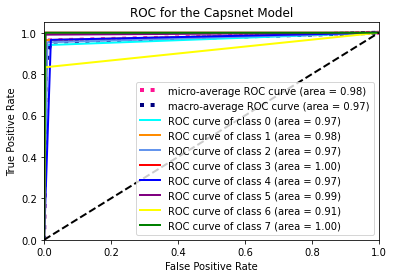

In [718]:
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

# ROC curve
# Compute ROC curve and ROC area for each class
Y_valid = label_binarize(y_true, classes=[i for i in range(len(y_labels))])
Y_pred = label_binarize(y_pred_2, classes=[i for i in range(len(y_labels))])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(y_labels)):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
nb_classes = len(y_labels)

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nb_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nb_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','blue', 'purple','yellow','green'])
for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for the Capsnet Model')
plt.legend(loc="lower right")
plt.savefig("ROC_brain.png", dpi= 400)
plt.show()


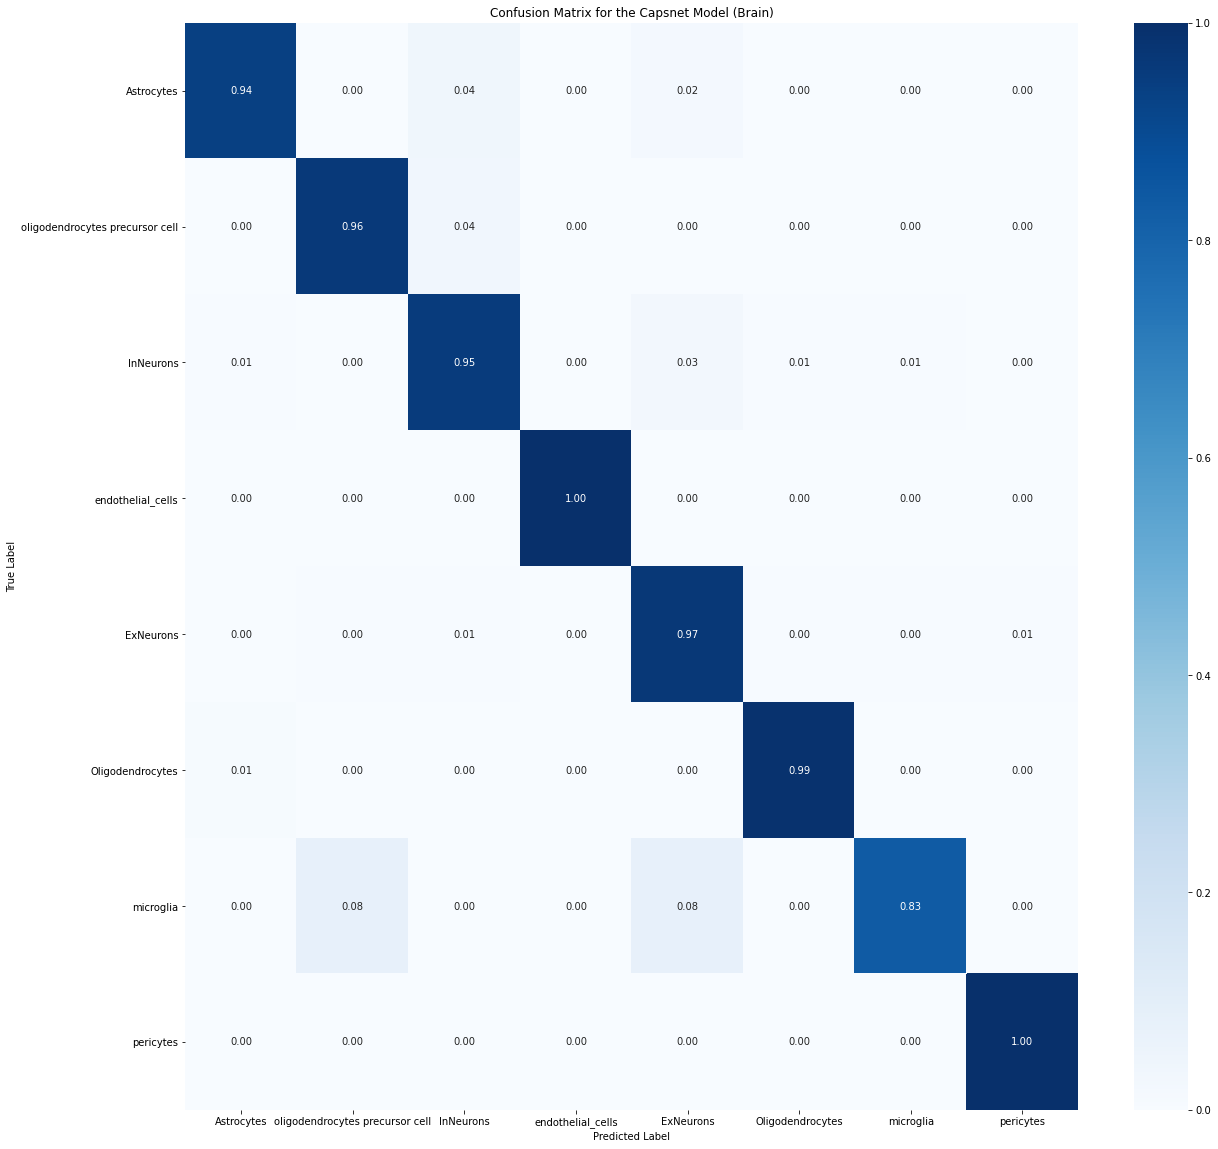

In [711]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pylab as plt

cf_results = confusion_matrix(y_true,y_pred,normalize='true')

plt.figure(figsize=(20,20))
ax = sns.heatmap(cf_results, cmap = 'Blues', annot=True, fmt = '.2f', xticklabels= list(y_labels), yticklabels= list(y_labels))
plt.title('Confusion Matrix for the Capsnet Model (Brain)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('Confusion Matrix for Capsnet_brain', dpi = 400)